In [1]:
%pip install gdstk tidy3d matplotlib numpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 535.7/535.7 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 36.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 67.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 72.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 6.8 MB/s eta 0:00:00
  Attempting uninstall: h5py
    Found existing installation: h5py 3.15.1
    Uninstalling h5py-3.15.1:
      Successfully uninstalled h5py-3.15.1
  Attempting uninstall: h5netcdf
    Found existing installation: h5netcdf 1.7.3
    Uninstalling h5netcdf-1.7.3:
      Successfully uninstalled h5netcdf-1.7.3


In [2]:
import gdstk
import matplotlib.pyplot as plt
import numpy as np
import tidy3d as td
import tidy3d.web as web
from tidy3d.plugins.mode import ModeSolver

In [3]:
import tidy3d.web as web
web.configure("Ibql1MdAL8o9sCstHbnB8tw3vXpdZpWviz6FlQ826ojd5pUy")

Configuration saved successfully.


In [4]:
w0 = 0.54  # width of the input/output single mode waveguides
w1 = 0.69  # width of the first tapper
w2 = 0.83  # width of the second tapper
w3 = 0.9  # width of the third tapper
w4 = 0.405  # width of the narrow waveguide
w_gap = 0.15  # gap of the directional coupler
L_tp1 = 4  # length of the first tapper
L_tp2 = 44  # length of the second tapper
L_tp3 = L_tp1 * (w3 - w2) / (w1 - w0)  # length of the third tapper
L_dc = 7  # length of the directional coupler
L_tpout = 14  # length of the output tapper
shift = 0.4  # shift of the narrow waveguide output
h_co = 0.22  # thickness of the waveguides
inf_eff = 1000  # effective infinity used to make sure the waveguides extend into pml

In [5]:
si = td.Medium(permittivity=3.455**2)
sio2 = td.Medium(permittivity=1.445**2)
si3n4 = td.Medium(permittivity=2**2)

In [6]:
cladding = td.Structure(
    geometry=td.Box.from_bounds(
        rmin=(-inf_eff, -inf_eff, -h_co / 2), rmax=(inf_eff, inf_eff, inf_eff)
    ),
    medium=si3n4,
)

vertices = np.array(
    [
        (-w0 / 2, -inf_eff),
        (-w0 / 2, 0),
        (-w1 / 2, L_tp1),
        (-w2 / 2, L_tp1 + L_tp2),
        (-w3 / 2, L_tp1 + L_tp2 + L_tp3),
        (-w3 / 2, L_tp1 + L_tp2 + L_tp3 + L_dc),
        (-w0 / 2, L_tp1 + L_tp2 + L_tp3 + L_dc + L_tpout),
        (-w0 / 2, inf_eff),
        (w0 / 2, inf_eff),
        (w0 / 2, L_tp1 + L_tp2 + L_tp3 + L_dc + L_tpout),
        (w3 / 2, L_tp1 + L_tp2 + L_tp3 + L_dc),
        (w3 / 2, L_tp1 + L_tp2 + L_tp3),
        (w2 / 2, L_tp1 + L_tp2),
        (w1 / 2, L_tp1),
        (w0 / 2, 0),
        (w0 / 2, -inf_eff),
    ]
)

wide_wg = td.Structure(
    geometry=td.PolySlab(vertices=vertices, axis=2, slab_bounds=(-h_co / 2, h_co / 2)),
    medium=si,
)

R = 100
cell = gdstk.Cell("bend")  # define a gds cell
bend = gdstk.FlexPath((-w3 / 2 - w_gap - w4 / 2, L_tp1 + L_tp2 + L_tp3), w4, layer=1, datatype=0)
bend.vertical(L_dc, relative=True)
bend.arc(R, 0, np.pi / 50)
bend.arc(R, -np.pi + np.pi / 50, -np.pi)
bend.vertical(inf_eff)
cell.add(bend)

# define the waveguide bend tidy3d geometries
bend_geo = td.PolySlab.from_gds(
    cell,
    gds_layer=1,
    axis=2,
    slab_bounds=(-h_co / 2, h_co / 2),
)[0]

narrow_wg = td.Structure(geometry=bend_geo, medium=si)

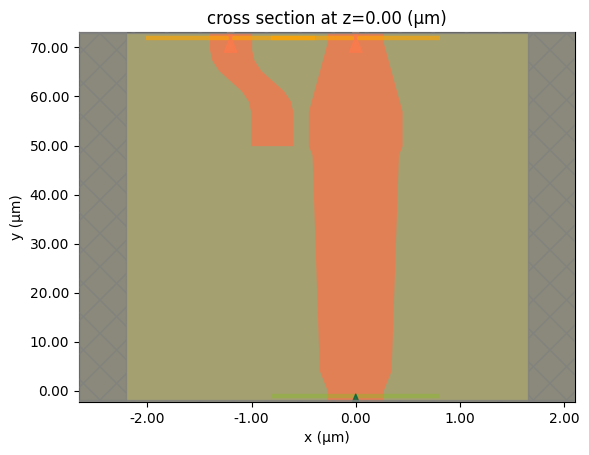

In [7]:
lda0 = 1.525  # central wavelength
freq0 = td.C_0 / lda0  # central frequency
ldas = np.linspace(1.45, 1.6, 101)  # wavelength range
freqs = td.C_0 / ldas  # frequency range

# buffer lengths in x and y directions
buffer_x = 1
buffer_y = 2

# simulation domain size
Lx = w3 + w_gap + w4 + shift + 2 * buffer_x
Ly = L_tp1 + L_tp2 + L_tp3 + L_dc + L_tpout + 2 * buffer_y
Lz = 10 * h_co
sim_size = (Lx, Ly, Lz)

# define mode source that launches the TE0 mode (mode_index=0). Later, we will modify it to investigate the TM0 mode case
mode_spec = td.ModeSpec(num_modes=2, target_neff=3)
mode_source = td.ModeSource(
    center=(0, -buffer_y / 2, 0),
    size=(3 * w0, 0, 5 * h_co),
    source_time=td.GaussianPulse(freq0=freq0, fwidth=freq0 / 10),
    direction="+",
    mode_spec=mode_spec,
    mode_index=0,
)

# define a field monitor
field_monitor = td.FieldMonitor(
    center=(0, -buffer_y / 2, 0), size=(td.inf, td.inf, 0), freqs=[freq0], name="field"
)

# define two flux monitors at the two outputs to measure transmission
output_y = Ly - 3 * buffer_y / 2
flux_monitor1 = td.FluxMonitor(
    center=(0, output_y, 0), size=(3 * w0, 0, 5 * h_co), freqs=freqs, name="flux1"
)

flux_monitor2 = td.FluxMonitor(
    center=(-w4 / 2 - w3 / 2 - w_gap - shift, output_y, 0),
    size=(3 * w0, 0, 5 * h_co),
    freqs=freqs,
    name="flux2",
)

# define two mode monitors at the two outputs to study output polarization
mode_monitor1 = td.ModeMonitor(
    center=(0, output_y, 0),
    size=(3 * w0, 0, 5 * h_co),
    freqs=freqs,
    mode_spec=mode_spec,
    name="mode1",
)

mode_monitor2 = td.ModeMonitor(
    center=(-w4 / 2 - w3 / 2 - w_gap - shift, output_y, 0),
    size=(3 * w0, 0, 5 * h_co),
    freqs=freqs,
    mode_spec=mode_spec,
    name="mode2",
)

# initialize the Simulation object
sim = td.Simulation(
    center=(-(shift + w_gap) / 2, Ly / 2 - buffer_y, 0),
    size=sim_size,
    grid_spec=td.GridSpec.auto(min_steps_per_wvl=20, wavelength=lda0),
    structures=[cladding, wide_wg, narrow_wg],
    sources=[mode_source],
    monitors=[
        field_monitor,
        flux_monitor1,
        flux_monitor2,
        mode_monitor1,
        mode_monitor2,
    ],
    run_time=2e-12,
    boundary_spec=td.BoundarySpec.all_sides(boundary=td.PML()),
    medium=sio2,
)

# plot the simulation at z=0 to inspect the structure, source, and monitors
fig = plt.figure()
ax = fig.add_subplot(111)
sim.plot(z=0, ax=ax)
ax.set_aspect("auto")